In [869]:
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal, rankdata
from matplotlib import pyplot as plt
from datetime import datetime

# Types
from collections.abc import Sequence
from typing import Literal
import numpy.typing as npt

## Data Generation

In [849]:
mu_0 = np.repeat(0, 10)
sigma_0 = np.zeros((10,10))
sigma_0[:4,:4] = 0.1
sigma_0[4:,4:] = 0.2
np.fill_diagonal(sigma_0, 1)
sigma_0

array([[1. , 0.1, 0.1, 0.1, 0. , 0. , 0. , 0. , 0. , 0. ],
       [0.1, 1. , 0.1, 0.1, 0. , 0. , 0. , 0. , 0. , 0. ],
       [0.1, 0.1, 1. , 0.1, 0. , 0. , 0. , 0. , 0. , 0. ],
       [0.1, 0.1, 0.1, 1. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 1. , 0.2, 0.2, 0.2, 0.2, 0.2],
       [0. , 0. , 0. , 0. , 0.2, 1. , 0.2, 0.2, 0.2, 0.2],
       [0. , 0. , 0. , 0. , 0.2, 0.2, 1. , 0.2, 0.2, 0.2],
       [0. , 0. , 0. , 0. , 0.2, 0.2, 0.2, 1. , 0.2, 0.2],
       [0. , 0. , 0. , 0. , 0.2, 0.2, 0.2, 0.2, 1. , 0.2],
       [0. , 0. , 0. , 0. , 0.2, 0.2, 0.2, 0.2, 0.2, 1. ]])

In [850]:
mu_1 = np.concatenate([np.repeat(1, 4), np.repeat(0,6)])
sigma_1 = np.zeros((10,10))
sigma_1[:4,:4] = 0.7
sigma_1[4:,4:] = 0.2
np.fill_diagonal(sigma_1, 1)
sigma_1

array([[1. , 0.7, 0.7, 0.7, 0. , 0. , 0. , 0. , 0. , 0. ],
       [0.7, 1. , 0.7, 0.7, 0. , 0. , 0. , 0. , 0. , 0. ],
       [0.7, 0.7, 1. , 0.7, 0. , 0. , 0. , 0. , 0. , 0. ],
       [0.7, 0.7, 0.7, 1. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 1. , 0.2, 0.2, 0.2, 0.2, 0.2],
       [0. , 0. , 0. , 0. , 0.2, 1. , 0.2, 0.2, 0.2, 0.2],
       [0. , 0. , 0. , 0. , 0.2, 0.2, 1. , 0.2, 0.2, 0.2],
       [0. , 0. , 0. , 0. , 0.2, 0.2, 0.2, 1. , 0.2, 0.2],
       [0. , 0. , 0. , 0. , 0.2, 0.2, 0.2, 0.2, 1. , 0.2],
       [0. , 0. , 0. , 0. , 0.2, 0.2, 0.2, 0.2, 0.2, 1. ]])

In [883]:
def generate_data(sample_size: tuple[int, int], seed: int, shuffle=True) -> tuple[npt.NDArray, npt.NDArray]:
    '''
    Parameters:
        sample_size: a tuple of (h0_size, h1_size)
        shuffle: should we shuffle the training data (otherwise the order will be: all h0 samples, then all h1 samples)
    Returns:
        tuple of (x_values, labels)
    '''
    np.random.seed(seed)
    
    # Generate the data
    x0 = multivariate_normal.rvs(mean=mu_0, cov=sigma_0, size=sample_size[0])
    x1 = multivariate_normal.rvs(mean=mu_1, cov=sigma_1, size=sample_size[1])
    x = np.concatenate([x0, x1], axis=0)
    y = np.concatenate([np.repeat(0,sample_size[0]), np.repeat(1,sample_size[1])])
    
    # shuffle if required 
    if shuffle:
        rng = np.random.default_rng(123)
        xy = np.concatenate([x, y.reshape(-1,1)],axis=1) # we want to shuffle x and y in the same order...
        rng.shuffle(xy)
        #split back to x_train and y_train
        x = xy[:,:10]
        y = xy[:,10:]
        y = y.reshape([-1]).astype(np.int64)
        
    print(F"Generated data shape for size {sample_size}:\r\n\tx: {x.shape}\r\n\t y: {y.shape}")
    return (x, y)

In [1301]:
test_data = generate_data((9000,1000), 0, shuffle=False)
train_100 = generate_data((50,50), 100)
train_10k = generate_data((5000,5000), 100)
train_200k = generate_data((100000,100000), 100)
calibration_2k = generate_data((1000,1000), 200)

Generated data shape for size (9000, 1000):
	x: (10000, 10)
	 y: (10000,)
Generated data shape for size (50, 50):
	x: (100, 10)
	 y: (100,)
Generated data shape for size (5000, 5000):
	x: (10000, 10)
	 y: (10000,)
Generated data shape for size (100000, 100000):
	x: (200000, 10)
	 y: (200000,)
Generated data shape for size (1000, 1000):
	x: (2000, 10)
	 y: (2000,)


## FDR using Optimal Classifier

In [889]:
log_f0 = multivariate_normal.logpdf(test_data[0], mean=mu_0, cov=sigma_0) # Get all values of x.mat as if it came from density f0
log_f0.shape

(10000,)

In [1459]:
sum(np.exp(log_f0))

0.0401478540949123

In [890]:
log_f1 = multivariate_normal.logpdf(test_data[0], mean=mu_1, cov=sigma_1) # Get all values of x.mat as if it came from density f1
log_f1.shape

(10000,)

In [891]:
# In Bayesian Decision Theory - The class with the highest posterior probability, is the one which provides the minimum risk
# So, fdr_vec is the "p values", which is actually the posterior calculated by [prior0 * Pr(f0|x)] / [(prior0 * Pr(f0|x)) + prior1*Pr(f1|x)]
fdr_vec = 0.90 * np.exp(log_f0) / (0.1*np.exp(log_f1) + 0.9*np.exp(log_f0)) 
fdr_vec.shape

(10000,)

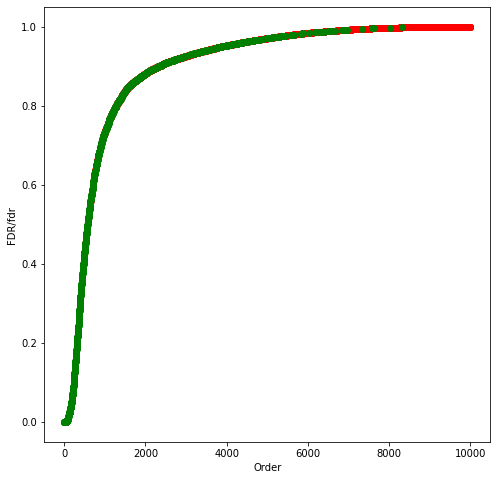

In [892]:
plt.figure(figsize=(8,8))
plt.scatter(rankdata(fdr_vec)[:9000], fdr_vec[:9000], marker="o", label="Ranked fdr", s=30 ,c='red')
plt.plot(rankdata(fdr_vec)[9000:], fdr_vec[9000:], marker="o", c='green', ls="none")
plt.xlabel("Order")
plt.ylabel("FDR/fdr")
plt.show()

In [893]:
num_rej = np.sum(np.cumsum(np.sort(fdr_vec))/np.arange(1,10000+1) <= 0.10)
print(F"num rej: {num_rej}")
# Find the number of false positives
pd.crosstab(rankdata(fdr_vec) <= num_rej,np.concatenate([np.repeat(True, 9000), np.repeat(False, 1000)]), colnames=['H0'], rownames=['is rejected'])

num rej: 393


H0,False,True
is rejected,,
False,650,8957
True,350,43


## Machine Learning

* MC Dropout MLP + CrossEntorpy using 10K Training Data
    * ratio 9:1 of h0/h1
    * ratio 5:5 of h0/h1
* MC Dropout MLP + CrossEntorpy using 100K Training Data
* LDA by sampling variance and mean
* Standard MLP + Softmax ?
* Standard MLP + Softmax + calibration?
* Random Forest? supervised / unsupervised?

In [894]:
import torch
from torch import nn
import torch.utils.data as Data
from torch.utils.data import Dataset as Dataset
import sklearn
from sklearn.model_selection import train_test_split

In [895]:
torch.set_default_dtype(torch.double)

### ML Infra

#### Dataloaders

In [937]:
class SimpleDataSet(Dataset):
    def __init__(self, x, y):
        super(SimpleDataSet, self).__init__()
        assert x.shape[0] == y.shape[0] # assuming shape[0] = dataset size
        self.x = x
        self.y = y

    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
def create_loader_for_data(data, batch_size=32, shuffle=True):
    dataset = SimpleDataSet(data[0], data[1])
    return Data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=shuffle)

def create_single_batch_loader_for_data(data, shuffle=True):
    return create_loader_for_data(data, batch_size=len(data[0]), shuffle=True)

#### Run Loop

In [624]:
def get_accuracy(model, data_loader):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''
    
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:
            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)  # The "1" is acutally misleading - it's the dimension to search the max in, *NOT* a value to compare to.
                                                        # This acutally returns the indices of the highest prediction for each row, 
                                                        # but since the index is 1-1 with the predicted digit, we use it as the label

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n

def plot_losses(train_losses, valid_losses):
    '''
    Function for plotting training and validation losses
    '''
    
    # temporarily change the style of the plots to seaborn 
    plt.style.use('seaborn')

    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss') 
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs", 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    fig.show()
    
    # change the plot style to default
    plt.style.use('default')

In [625]:
def epoch_step(loader, criterion, model, optimizer, train=True):
    '''
    Implementation a single epoch for the training/validation loop.
    '''        
    
    model.train() if train else model.eval() # Set the currnet mode
    
    running_loss = 0
    
    # Each iteration gets a batch from the train loader
    for X, y_true in loader:
        optimizer.zero_grad() if train else None
        
        # Forward pass
        y_hat, _ = model(X)
        loss = criterion(y_hat, y_true)
        running_loss += loss.item() * X.size(0) # X.size(0) is the size of the BATCH, thi is required for calculating the avg loss 
                                                # of the epoch step.
        
        # Backward pass, only required in training the model
        if train:
            loss.backward()
            optimizer.step()
    
    epoch_loss = running_loss / len(loader.dataset)
    return model, optimizer, epoch_loss

In [923]:
def run_loop(train_loader, validation_loader, criterion, model, optimizer, num_epochs, print_every=1):
    
    # Objects for storing metrics
    best_loss = 1e10
    train_losses = []
    validation_losses = []
    
    for epoch in range(num_epochs):
        #print(f'Epoch: {epoch}\t')
        
        # Training the model
        model, optimizer, train_loss = epoch_step(train_loader, criterion, model, optimizer)
        train_losses.append(train_loss)
        
        
        # # Validation
        # with torch.no_grad():
        #     model, _, validation_loss = epoch_step(validation_loader, criterion, model, None, False)
        #     validation_losses.append(validation_loss)
        
        if epoch % print_every == 0:
            # train_accuracy = get_accuracy(model, train_loader)
            # validation_accuracy = get_accuracy(model, validation_loader)
            
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  # f'Vaildation loss: {validation_loss:.4f}\t'
                  # f'Train accuracy: {100 * train_accuracy:.2f}\t'
                  # f'Vaildation accuracy: {100 * validation_accuracy:.2f}\t'
                  )
            
    # plot_losses(train_losses, validation_losses)
    
    return model, optimizer, (train_losses, validation_losses)

#### Deep Bayes

In [627]:
from torch import Tensor
from torch.nn import functional as F

# Defining a dropout layer to also be used for testing
class MCDropout(torch.nn.Dropout):
    def forward(self, input: Tensor) -> Tensor:
        return F.dropout(input, self.p, True, self.inplace)

### Model

In [1280]:
class DropoutFdr(nn.Module):
    
    def __init__(self):
        
        super(DropoutFdr, self).__init__()
        
        self.classifier = nn.Sequential(
                            torch.nn.Linear(in_features=10, out_features=100),
                            torch.nn.ReLU(),
                            MCDropout(0.30),
                            torch.nn.Linear(in_features=100, out_features=100),
                            torch.nn.ReLU(),
                            MCDropout(0.30),
                            torch.nn.Linear(in_features=100, out_features=10),
                            torch.nn.ReLU(),
                            MCDropout(0.30),
                            torch.nn.Linear(in_features=10, out_features=2)
        )
        
    def forward(self, x):
        logits = self.classifier(x)
        probabilities = F.softmax(logits, dim=1)
        return logits, probabilities

In [1304]:
class NoDropoutFdr(nn.Module):
    
    def __init__(self):
        
        super(NoDropoutFdr, self).__init__()
        
        self.classifier = nn.Sequential(
                            torch.nn.Linear(in_features=10, out_features=100),
                            torch.nn.ReLU(),
                            torch.nn.Linear(in_features=100, out_features=100),
                            torch.nn.ReLU(),
                            torch.nn.Linear(in_features=100, out_features=10),
                            torch.nn.ReLU(),
                            torch.nn.Linear(in_features=10, out_features=2)
        )
        
    def forward(self, x):
        logits = self.classifier(x)
        probabilities = F.softmax(logits, dim=1)
        return logits, probabilities

In [1290]:
class DropoutFdrWithTemperature(nn.Module):
    
    def __init__(self):
        
        super(DropoutFdrWithTemperature, self).__init__()
        self.temperature = nn.Parameter(torch.ones(1) * 1.5)
        self.classifier = nn.Sequential(
                            torch.nn.Linear(in_features=10, out_features=100),
                            torch.nn.ReLU(),
                            MCDropout(0.30),
                            torch.nn.Linear(in_features=100, out_features=100),
                            torch.nn.ReLU(),
                            MCDropout(0.30),
                            torch.nn.Linear(in_features=100, out_features=10),
                            torch.nn.ReLU(),
                            MCDropout(0.30),
                            torch.nn.Linear(in_features=10, out_features=2)
        )
        
    def forward(self, x):
        logits = self.classifier(x)
        temperature = self.temperature.unsqueeze(1).expand(logits.size(0), logits.size(1))
        scaled_logits = logits/temperature
        probabilities = F.softmax(scaled_logits, dim=1)
        return logits, probabilities

In [700]:
loss_func = torch.nn.CrossEntropyLoss()

In [701]:
learning_rate = 1e-3

In [1317]:
model_10k = DropoutFdr()
optimizer_10k = torch.optim.Adam(model_10k.parameters(), lr=learning_rate)

In [1318]:
model_10k_regul = DropoutFdr()
optimizer_10k_regul = torch.optim.Adam(model_10k_regul.parameters(), lr=learning_rate, weight_decay=0.01)
# def regularized_CE(model):
#     lamdba = 0.1
#     original_loss = torch.nn.CrossEntropyLoss()
#     def finalized_loss(y_hat, y_true):
#         norm = sum(abs(p).sum() for p in model.parameters())
#         return original_loss(y_hat, y_true) + lamdba*norm

#     return finalized_loss
# regul_loss_func = regularized_CE(model_10k_regul)

In [1293]:
model_10k_temp = DropoutFdrWithTemperature()
optimizer_10k_temp = torch.optim.Adam(model_10k_temp.parameters(), lr=learning_rate)

In [924]:
model_200k = DropoutFdr()
optimizer_200k = torch.optim.Adam(model_200k.parameters(), lr=learning_rate)

### Training

In [1319]:
# train_10k_loader = create_loader_for_data(train_10k) # GD (not SGD)
train_10k_loader = create_single_batch_loader_for_data(train_10k) # GD (not SGD)
train_200k_loader = create_single_batch_loader_for_data(train_200k) # GD (not SGD)
test_loader = create_loader_for_data(test_data, shuffle=False)

In [1320]:
model_10k_trained, optimizer_10k_trained, _ = run_loop(train_10k_loader, test_loader, loss_func, model_10k, optimizer_10k, 1000,100)

13:02:16 --- Epoch: 0	Train loss: 0.6988	
13:02:28 --- Epoch: 100	Train loss: 0.4331	
13:02:39 --- Epoch: 200	Train loss: 0.4012	
13:02:53 --- Epoch: 300	Train loss: 0.3945	
13:03:06 --- Epoch: 400	Train loss: 0.3886	
13:03:19 --- Epoch: 500	Train loss: 0.3804	
13:03:31 --- Epoch: 600	Train loss: 0.3764	
13:03:43 --- Epoch: 700	Train loss: 0.3702	
13:03:55 --- Epoch: 800	Train loss: 0.3702	
13:04:08 --- Epoch: 900	Train loss: 0.3614	


In [1321]:
model_10k_regul_trained, optimizer_10k_regul_trained, _ = run_loop(train_10k_loader, test_loader, loss_func, model_10k_regul, optimizer_10k_regul, 1000,100)

13:05:13 --- Epoch: 0	Train loss: 0.7173	
13:05:25 --- Epoch: 100	Train loss: 0.4774	
13:05:38 --- Epoch: 200	Train loss: 0.4221	
13:05:52 --- Epoch: 300	Train loss: 0.4118	
13:06:05 --- Epoch: 400	Train loss: 0.4060	
13:06:18 --- Epoch: 500	Train loss: 0.4055	
13:06:30 --- Epoch: 600	Train loss: 0.4048	
13:06:43 --- Epoch: 700	Train loss: 0.4021	
13:06:56 --- Epoch: 800	Train loss: 0.4024	
13:07:08 --- Epoch: 900	Train loss: 0.4046	


In [1294]:
model_10k_temp_trained, optimizer_10k_temp_trained, _ = run_loop(train_10k_loader, test_loader, loss_func, model_10k_temp, optimizer_10k_temp, 1000,100)

12:33:25 --- Epoch: 0	Train loss: 0.6976	
12:33:37 --- Epoch: 100	Train loss: 0.4275	
12:33:49 --- Epoch: 200	Train loss: 0.3979	
12:34:01 --- Epoch: 300	Train loss: 0.3874	
12:34:12 --- Epoch: 400	Train loss: 0.3804	
12:34:24 --- Epoch: 500	Train loss: 0.3732	
12:34:36 --- Epoch: 600	Train loss: 0.3691	
12:34:48 --- Epoch: 700	Train loss: 0.3677	
12:35:00 --- Epoch: 800	Train loss: 0.3634	
12:35:12 --- Epoch: 900	Train loss: 0.3554	


In [941]:
model_200k_trained, optimizer_200k_trained, _ = run_loop(train_200k_loader, test_loader, loss_func, model_200k, optimizer_200k, 1000,100)

10:06:02 --- Epoch: 0	Train loss: 0.6978	
10:10:51 --- Epoch: 100	Train loss: 0.4310	
10:15:32 --- Epoch: 200	Train loss: 0.4050	
10:20:11 --- Epoch: 300	Train loss: 0.4002	
10:24:47 --- Epoch: 400	Train loss: 0.3976	
10:29:22 --- Epoch: 500	Train loss: 0.3964	
10:33:57 --- Epoch: 600	Train loss: 0.3954	
10:38:36 --- Epoch: 700	Train loss: 0.3944	
10:44:23 --- Epoch: 800	Train loss: 0.3936	
10:50:09 --- Epoch: 900	Train loss: 0.3934	


In [948]:
import copy
copied_200k_model = copy.deepcopy(model_200k_trained)

### Small Data

In [1338]:
train_100_loader = create_single_batch_loader_for_data(train_100) # GD (not SGD)

In [1329]:
model_100_no_drop = NoDropoutFdr()
optimizer_100_no_drop = torch.optim.Adam(model_100_no_drop.parameters(), lr=learning_rate)

In [1330]:
model_100_dropout = DropoutFdr()
optimizer_100_dropout = torch.optim.Adam(model_100_dropout.parameters(), lr=learning_rate)

In [1331]:
model_100_no_drop_regul = NoDropoutFdr()
optimizer_100_no_drop_regul = torch.optim.Adam(model_100_no_drop_regul.parameters(), lr=learning_rate)

#### Training

In [1335]:
model_100_no_drop_trained, optimizer_100_no_drop_trained, _ = run_loop(train_100_loader, test_loader, loss_func, model_100_no_drop, optimizer_100_no_drop, 50,10)

13:11:19 --- Epoch: 0	Train loss: 0.2941	
13:11:19 --- Epoch: 10	Train loss: 0.2395	
13:11:19 --- Epoch: 20	Train loss: 0.1857	
13:11:19 --- Epoch: 30	Train loss: 0.1384	
13:11:19 --- Epoch: 40	Train loss: 0.1022	


In [1337]:
model_100_dropout_trained, optimizer_100_dropout_trained, _ = run_loop(train_100_loader, test_loader, loss_func, model_100_dropout, optimizer_100_dropout, 50,10)

13:11:24 --- Epoch: 0	Train loss: 0.4544	
13:11:24 --- Epoch: 10	Train loss: 0.3926	
13:11:24 --- Epoch: 20	Train loss: 0.3731	
13:11:24 --- Epoch: 30	Train loss: 0.3491	
13:11:24 --- Epoch: 40	Train loss: 0.3453	


In [1339]:
model_100_no_drop_regul_trained, optimizer_100_no_drop_regul_trained, _ = run_loop(train_100_loader, test_loader, loss_func, model_100_no_drop_regul, optimizer_100_no_drop_regul, 50,10)

13:11:32 --- Epoch: 0	Train loss: 0.6974	
13:11:32 --- Epoch: 10	Train loss: 0.6122	
13:11:32 --- Epoch: 20	Train loss: 0.5077	
13:11:32 --- Epoch: 30	Train loss: 0.4126	
13:11:32 --- Epoch: 40	Train loss: 0.3481	


### Calibrating

#### Temperature Scaling

In [1054]:
import temperature_scaling

def T_scale_model(trained_model, calibration_data):
    calibration_dataset = SimpleDataSet(calibration_data[0], calibration_data[1])
    calibration_loader = Data.DataLoader(dataset=calibration_dataset)
    scaled_model = temperature_scaling.ModelWithTemperature(trained_model)
    scaled_model.set_temperature(calibration_loader)
    return scaled_model


In [1201]:
t_scaled_model_10k = T_scale_model(model_10k_trained, calibration_2k)
t_scaled_model_200k = T_scale_model(model_200k_trained, calibration_2k)

set temperature
Before temperature - NLL: 0.424, ECE: 0.027
Optimal temperature: 1.418
After temperature - NLL: 0.417, ECE: 0.023
set temperature
Before temperature - NLL: 0.395, ECE: 0.012
Optimal temperature: 1.198
After temperature - NLL: 0.398, ECE: 0.030


#### Platt Scaling

In [1192]:
from sklearn.linear_model import LogisticRegression as LR
from sklearn.isotonic import IsotonicRegression as IR

class PlattScaledModel(nn.Module):
    def __init__(self, model):
        super(PlattScaledModel, self).__init__()
        self.model = model
        self.lr = None
    
    def scale_model(self, calibration_data):
        self.lr = LR()

        # Make predictions
        pos_class_preds_tensor_list = []
        X = torch.from_numpy(calibration_data[0]).view([-1,10])
        with torch.no_grad():
            for _ in range(100):
                _, all_class_probabilities = self.model(X)   
                pos_class_preds_tensor_list.append(all_class_probabilities[:,1].reshape((-1,1)))

        preds_tensor = torch.cat(pos_class_preds_tensor_list, dim=1)
        preds_std = torch.std(preds_tensor, 1, True).numpy()
        preds_mean = torch.mean(preds_tensor, 1).numpy()
        
        # Calibrate
        self.lr.fit(preds_mean.reshape(-1,1), calibration_data[1])
    
    def forward(self, input):
        if self.lr is None:
            raise "Model was not calibrated!"
        
        logits, probabilities = self.model(input)
        scaled_probabilities = self.lr.predict_proba(probabilities[:,1].reshape(-1,1).numpy())[:,1]
        return logits, torch.cat([torch.zeros(len(scaled_probabilities)).reshape(-1,1),torch.from_numpy(scaled_probabilities).reshape(-1,1)], dim=1)

class IsotonicModel(nn.Module):
    def __init__(self, model):
        super(IsotonicModel, self).__init__()
        self.model = model
        self.ir = None
    
    def scale_model(self, calibration_data):
        self.ir = IR(out_of_bounds="clip")

        # Make predictions
        pos_class_preds_tensor_list = []
        X = torch.from_numpy(calibration_data[0]).view([-1,10])
        with torch.no_grad():
            for _ in range(100):
                _, all_class_probabilities = self.model(X)   
                pos_class_preds_tensor_list.append(all_class_probabilities[:,1].reshape((-1,1)))

        preds_tensor = torch.cat(pos_class_preds_tensor_list, dim=1)
        preds_std = torch.std(preds_tensor, 1, True).numpy()
        preds_mean = torch.mean(preds_tensor, 1).numpy()
        
        # Calibrate
        self.ir.fit(preds_mean.reshape(-1,1), calibration_data[1])
    
    def forward(self, input):
        if self.ir is None:
            raise "Model was not calibrated!"
        
        logits, probabilities = self.model(input)
        scaled_probabilities = self.ir.transform(probabilities[:,1].reshape(-1,1).numpy())
        return logits, torch.cat([torch.zeros(len(scaled_probabilities)).reshape(-1,1),torch.from_numpy(scaled_probabilities).reshape(-1,1)], dim=1)

In [1202]:
platt_scaled_model_10k = PlattScaledModel(model_10k_trained)
platt_scaled_model_10k.scale_model(calibration_2k)
platt_scaled_model_200k = PlattScaledModel(model_200k_trained)
platt_scaled_model_200k.scale_model(calibration_2k)

In [1203]:
iso_scaled_model_10k = IsotonicModel(model_10k_trained)
iso_scaled_model_10k.scale_model(calibration_2k)
iso_scaled_model_200k = IsotonicModel(model_200k_trained)
iso_scaled_model_200k.scale_model(calibration_2k)

### Testing

#### MC Dropout

In [1274]:
def test_model(model, test_data): 
    all_pred_tensor_list = []
    X = torch.from_numpy(test_data[0]).view([-1,10])
    with torch.no_grad():
        for _ in range(100):
            _, all_class_probabilities = model(X)    
            all_pred_tensor_list.append(all_class_probabilities[:,1].reshape((-1,1)))

    all_preds_tensor = torch.cat(all_pred_tensor_list, dim=1)
    all_preds = all_preds_tensor.numpy()
    all_preds_std = torch.std(all_preds_tensor, 1, True).numpy()
    all_preds_mean = torch.mean(all_preds_tensor, 1).numpy()
    all_preds_median = torch.median(all_preds_tensor, 1).values.numpy()
    return (all_preds, all_preds_mean, all_preds_std, all_preds_median)

In [1205]:
_, preds_mean_10k_T_scaled, preds_std_10k_T_scaled,_ = test_model(t_scaled_model_10k, test_data)
_, preds_mean_200k_T_scaled, preds_std_200k_T_scaled, _ = test_model(t_scaled_model_200k, test_data)
_, preds_mean_10k_platt_scaled, preds_std_10k_platt_scaled,_ = test_model(platt_scaled_model_10k, test_data)
_, preds_mean_200k_platt_scaled, preds_std_200k_platt_scaled, _ = test_model(platt_scaled_model_200k, test_data)

In [1206]:
_, preds_mean_10k_iso_scaled, preds_std_10k_iso_scaled,_ = test_model(iso_scaled_model_10k, test_data)
_, preds_mean_200k_iso_scaled, preds_std_200k_iso_scaled, _ = test_model(iso_scaled_model_200k, test_data)

In [1275]:
_, preds_mean_10k, preds_std_10k, _ = test_model(model_10k_trained, test_data)

In [1351]:
preds_mean_10k_with_std = np.clip(preds_mean_10k + (abs(preds_std_10k)), 0,1)
preds_mean_10k_with_std

array([0.0033307 , 0.5201024 , 0.02065489, ..., 1.        , 1.        ,
       0.63842487])

In [1275]:
_, preds_mean_200k, preds_std_200k, _ = test_model(model_200k_trained, test_data)

In [1322]:
_, preds_mean_10k_regul, preds_std_10k_regul,_ = test_model(model_10k_regul_trained, test_data)

In [1295]:
_, preds_mean_10k_temp, preds_std_10k_temp,_ = test_model(model_10k_temp_trained, test_data)

#### Small Data testing

In [1340]:
_, preds_mean_100_no_drop, preds_std_100_no_drop,_ = test_model(model_100_no_drop_trained, test_data)

In [1341]:
_, preds_mean_100_no_drop_regul, preds_std_100_no_drop_regul,_ = test_model(model_100_no_drop_regul_trained, test_data)

In [1342]:
_, preds_mean_100_dropout, preds_std_100_dropout,_ = test_model(model_100_dropout_trained, test_data)

#### Predictions

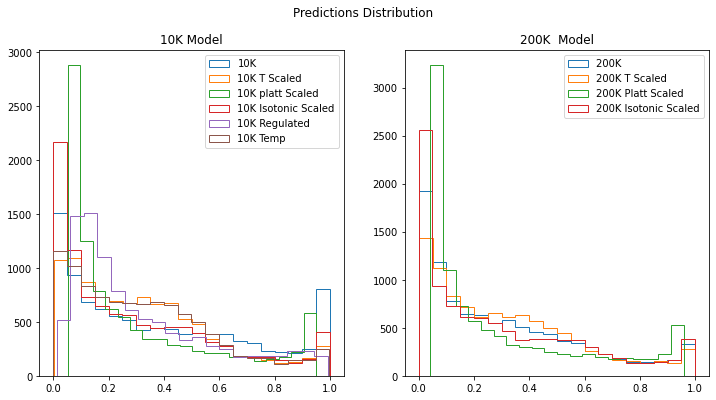

In [1352]:
preds_fig, (preds_ax1, preds_ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
preds_fig.suptitle('Predictions Distribution')
preds_ax1.hist(preds_mean_10k_with_std, 20, histtype="step", label="10K")
preds_ax1.hist(preds_mean_10k_T_scaled, 20, histtype="step",label="10K T Scaled")
preds_ax1.hist(preds_mean_10k_platt_scaled, 20, histtype="step",label="10K platt Scaled")
preds_ax1.hist(preds_mean_10k_iso_scaled, 20, histtype="step",label="10K Isotonic Scaled")
preds_ax1.hist(preds_mean_10k_regul, 20, histtype="step",label="10K Regulated")
preds_ax1.hist(preds_mean_10k_temp, 20, histtype="step",label="10K Temp")
preds_ax1.set_title("10K Model")
preds_ax1.legend()
preds_ax2.hist(preds_mean_200k, 20, histtype="step", label="200K ")
preds_ax2.hist(preds_mean_200k_T_scaled, 20, histtype="step", label="200K T Scaled")
preds_ax2.hist(preds_mean_200k_platt_scaled, 20, histtype="step", label="200K Platt Scaled")
preds_ax2.hist(preds_mean_200k_iso_scaled, 20, histtype="step", label="200K Isotonic Scaled")
preds_ax2.set_title("200K  Model")
preds_ax2.legend()
plt.show()

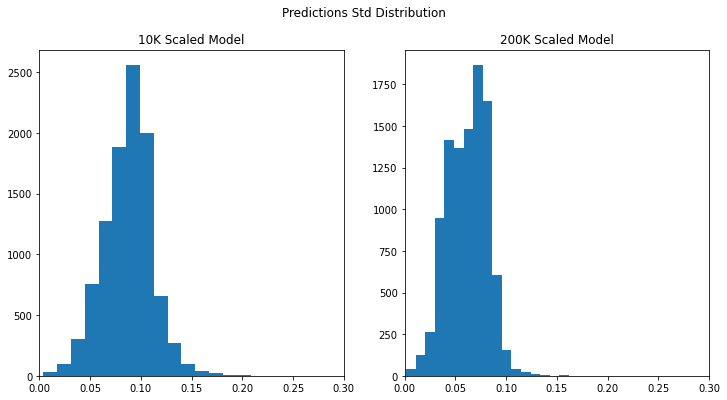

In [1062]:
std_fig, (std_ax1, std_ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
std_fig.suptitle('Predictions Std Distribution')
std_ax1.hist(all_preds_std_10k_scaled, 20)
std_ax1.set_title("10K Scaled Model")
std_ax1.set_xlim(0,0.3)
std_ax2.hist(all_preds_std_200k_scaled, 20)
std_ax2.set_title("200K Scaled Model")
std_ax2.set_xlim(0,0.3)
plt.show()

#### Reliability Plots

In [1191]:
preds_mean_10k_iso_scaled

array([       nan, 0.38752057,        nan, ...,        nan,        nan,
       0.38108248])

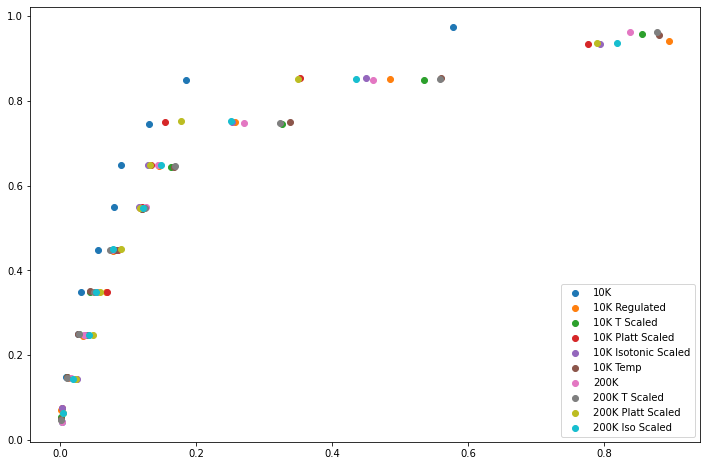

In [1354]:
from sklearn.calibration import calibration_curve

y_true = test_data[1]
calibration_data_10k = calibration_curve(y_true, preds_mean_10k_with_std,n_bins=10)
calibration_data_10k_regul = calibration_curve(y_true, preds_mean_10k_regul,n_bins=10)
calibration_data_10k_T_scaled = calibration_curve(y_true, preds_mean_10k_T_scaled,n_bins=10)
calibration_data_10k_platt_scaled = calibration_curve(y_true, preds_mean_10k_platt_scaled,n_bins=10)
calibration_data_10k_iso_scaled = calibration_curve(y_true, preds_mean_10k_iso_scaled,n_bins=10)
calibration_data_10k_temp = calibration_curve(y_true, preds_mean_10k_temp,n_bins=10)
calibration_data_200k = calibration_curve(y_true, preds_mean_200k,n_bins=10)
calibration_data_200k_T_scaled = calibration_curve(y_true, preds_mean_200k_T_scaled,n_bins=10)
calibration_data_200k_platt_scaled = calibration_curve(y_true, preds_mean_200k_platt_scaled,n_bins=10)
calibration_data_200k_iso_scaled = calibration_curve(y_true, preds_mean_200k_iso_scaled,n_bins=10)

plt.figure(figsize=(12,8))
plt.scatter(calibration_data_10k[0], calibration_data_10k[1], label="10K")
plt.scatter(calibration_data_10k_regul[0], calibration_data_10k_regul[1], label="10K Regulated")
plt.scatter(calibration_data_10k_T_scaled[0], calibration_data_10k_T_scaled[1], label="10K T Scaled")
plt.scatter(calibration_data_10k_platt_scaled[0], calibration_data_10k_platt_scaled[1], label="10K Platt Scaled")
plt.scatter(calibration_data_10k_iso_scaled[0], calibration_data_10k_platt_scaled[1], label="10K Isotonic Scaled")
plt.scatter(calibration_data_10k_temp[0], calibration_data_10k_temp[1], label="10K Temp")
plt.scatter(calibration_data_200k[0], calibration_data_200k[1], label="200K")
plt.scatter(calibration_data_200k_T_scaled[0], calibration_data_200k_T_scaled[1], label="200K T Scaled")
plt.scatter(calibration_data_200k_platt_scaled[0], calibration_data_200k_platt_scaled[1], label="200K Platt Scaled")
plt.scatter(calibration_data_200k_iso_scaled[0], calibration_data_200k_platt_scaled[1], label="200K Iso Scaled")
plt.legend(loc="lower right")
plt.show()

#### Generate p-values

(array([ 242.,  140.,  137.,  118.,  138.,  186.,  193.,  295.,  325.,
         499.,  618.,  660.,  689.,  673.,  623.,  674.,  654.,  802.,
         982., 1352.]),
 array([9.85337028e-04, 5.09246311e-02, 1.00863925e-01, 1.50803219e-01,
        2.00742513e-01, 2.50681807e-01, 3.00621102e-01, 3.50560396e-01,
        4.00499690e-01, 4.50438984e-01, 5.00378278e-01, 5.50317572e-01,
        6.00256866e-01, 6.50196160e-01, 7.00135454e-01, 7.50074748e-01,
        8.00014042e-01, 8.49953336e-01, 8.99892630e-01, 9.49831925e-01,
        9.99771219e-01]),
 <BarContainer object of 20 artists>)

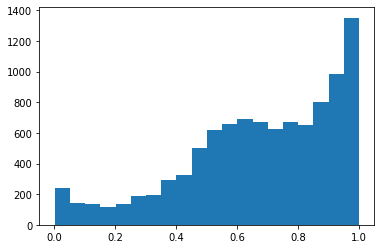

In [751]:
# p_values = torch.clamp((1-all_preds_median.values)+(all_preds_std**2), max=1)
p_values = 1-all_preds_mean
# p_values = torch.clamp((1-all_preds_mean)+(all_preds_std**2), max=1)
plt.hist(p_values.numpy(), 20)

In [1218]:
# num_rej = np.sum(np.cumsum(np.sort(p_values.numpy()))/np.arange(1,10000+1) <= 0.10)
p_values = 1-preds_mean_10k
num_rej = np.sum((p_values < 0.1).numpy())
print(F"num rej: {num_rej}")
# Find the number of false positives
pd.crosstab(rankdata(p_values) <= num_rej,np.concatenate([np.repeat(True, 9000), np.repeat(False, 1000)]), colnames=['H0'], rownames=['is rejected'])

AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

In [753]:
fpr, tpr, threasholds = sklearn.metrics.roc_curve(np.concatenate([np.repeat(False, 9000), np.repeat(True, 1000)]),p_values.numpy())

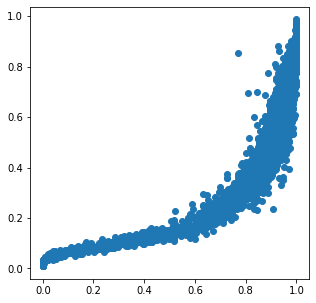

In [1325]:
plt.figure(figsize=(5,5))
plt.scatter(fdr_vec, 1-preds_mean_10k_regul)
# plt.scatter(fdr_vec[fdr_vec<0.2], p_values[fdr_vec<0.2])

## Discriminant Analysis


In [1369]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, precision_score

### LDA

In [1370]:
# lda = LinearDiscriminantAnalysis(priors=[0.9,0.1])
lda = LinearDiscriminantAnalysis()

In [1371]:
lda_model = lda.fit(train_10k[0], train_10k[1])

In [1372]:
print(F"priors: {lda_model.priors_}")
print(F"means: {lda_model.means_}")
print(F"Coeffs: {lda_model.coef_}")

priors: [0.5 0.5]
means: [[ 0.02384398 -0.00791645 -0.01128096  0.00233339 -0.00501667 -0.0043035
   0.01104084  0.00595032 -0.00767235  0.02285634]
 [ 0.99592489  1.00199357  1.00482415  0.9923917   0.00617766  0.01118413
  -0.01644544 -0.00125865 -0.00211109  0.01100623]]
Coeffs: [[ 0.41889829  0.46974849  0.47443701  0.45871998  0.02046772  0.03626166
  -0.02794636  0.00355071  0.00725617 -0.0322791 ]]


In [1373]:
lda_predictions = lda.predict(test_data[0])
lda_probabilities = lda.predict_proba(test_data[0])
lda_p_values = 1 - lda_probabilities[:,1]

In [1374]:
print(confusion_matrix(y_vec, lda_predictions))

[[7300 1700]
 [ 282  718]]


### QDA

In [1375]:
# qda = QuadraticDiscriminantAnalysis(priors=[0.9,0.1])
qda = QuadraticDiscriminantAnalysis()

In [1376]:
qda_model = qda.fit(train_10k[0], train_10k[1])

In [1377]:
print(F"priors: {qda_model.priors_}")
print(F"means: {qda_model.means_}")

priors: [0.5 0.5]
means: [[ 0.02384398 -0.00791645 -0.01128096  0.00233339 -0.00501667 -0.0043035
   0.01104084  0.00595032 -0.00767235  0.02285634]
 [ 0.99592489  1.00199357  1.00482415  0.9923917   0.00617766  0.01118413
  -0.01644544 -0.00125865 -0.00211109  0.01100623]]


In [1379]:
qda_predictions = qda.predict(test_data[0])
qda_probabilities = qda.predict_proba(test_data[0])
qda_p_values = 1 - qda_probabilities[:,1]

In [1380]:
print(confusion_matrix(y_vec, qda_predictions))

[[7474 1526]
 [ 201  799]]


#### Discriminant Analysis Graphs

LDA confusion:
 [[7300 1700]
 [ 282  718]]

QDA confusion:
 [[7474 1526]
 [ 201  799]]



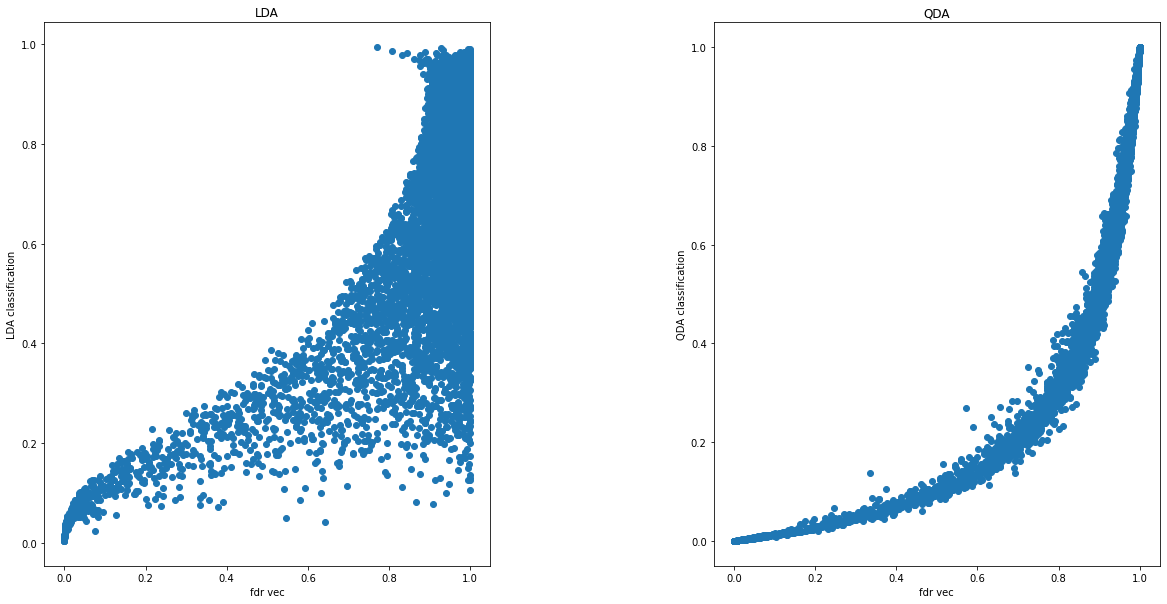

In [1381]:
fig = plt.figure(figsize=(20,10))
gs = fig.add_gridspec(1,2, wspace=0.5)
axes = gs.subplots()
lda_plot = axes[0]
qda_plot = axes[1]

lda_plot.scatter(fdr_vec, lda_p_values)
lda_plot.set_title("LDA")
lda_plot.set_xlabel("fdr vec")
lda_plot.set_ylabel("LDA classification")

qda_plot.scatter(fdr_vec, qda_p_values)
qda_plot.set_title("QDA")
qda_plot.set_xlabel("fdr vec")
qda_plot.set_ylabel("QDA classification")

print(F"LDA confusion:\n {confusion_matrix(y_vec, lda_predictions)}\n")
print(F"QDA confusion:\n {confusion_matrix(y_vec, qda_predictions)}\n")

Text(0, 0.5, 'QDA for FDR<0.2')

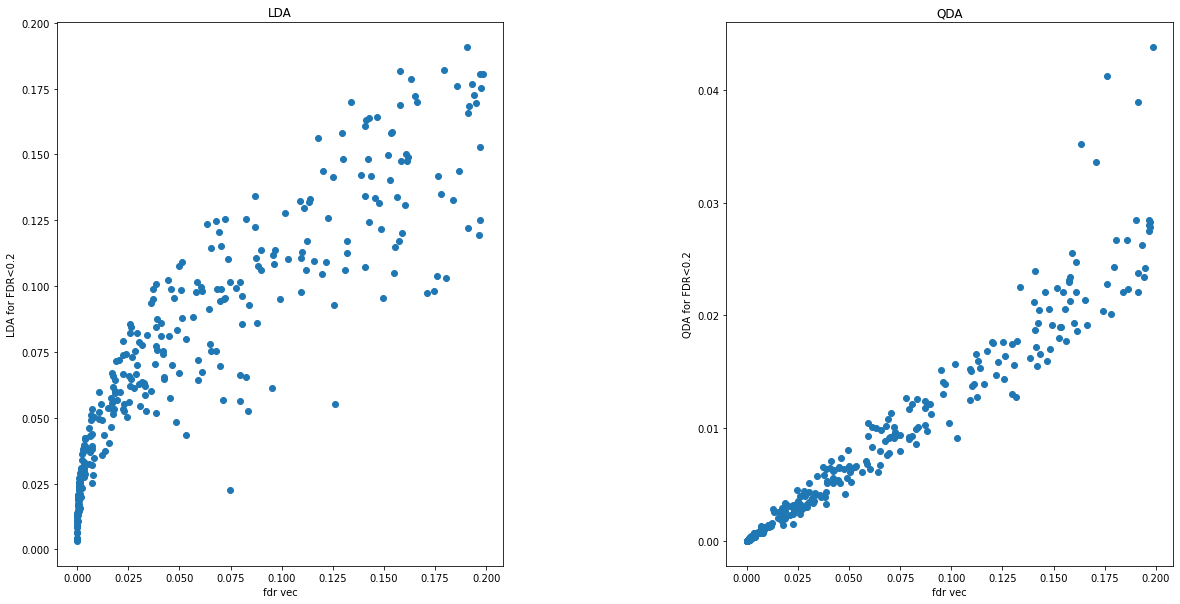

In [1382]:
fig = plt.figure(figsize=(20,10))
gs = fig.add_gridspec(1,2, wspace=0.5)
axes = gs.subplots()
lda_02_plot = axes[0]
qda_02_plot = axes[1]

lda_02_plot.scatter(fdr_vec[fdr_vec<0.2], lda_p_values[fdr_vec<0.2])
lda_02_plot.set_title("LDA")
lda_02_plot.set_xlabel("fdr vec")
lda_02_plot.set_ylabel("LDA for FDR<0.2")

qda_02_plot.scatter(fdr_vec[fdr_vec<0.2], qda_p_values[fdr_vec<0.2])
qda_02_plot.set_title("QDA")
qda_02_plot.set_xlabel("fdr vec")
qda_02_plot.set_ylabel("QDA for FDR<0.2")


#### Small Data QDA

In [1441]:
small_qda = QuadraticDiscriminantAnalysis(priors=[0.9,0.1])
# small_qda = QuadraticDiscriminantAnalysis()

In [1442]:
small_qda_model = small_qda.fit(train_100[0], train_100[1])

In [1443]:
print(F"priors: {small_qda_model.priors_}")
print(F"means: {small_qda_model.means_}")

priors: [0.9 0.1]
means: [[ 0.08997517 -0.21400335 -0.09894476  0.07345995  0.19826779  0.00989906
  -0.01210475  0.3781667  -0.01276003  0.11392558]
 [ 0.99839317  0.99678754  1.01439457  0.94277538 -0.26625576 -0.22462946
   0.01780575 -0.02984185  0.111969   -0.13808893]]


In [1444]:
small_qda_predictions = small_qda.predict(test_data[0])
small_qda_probabilities = small_qda.predict_proba(test_data[0])
small_qda_p_values = 1 - small_qda_probabilities[:,1]

In [1445]:
print(confusion_matrix(test_data[1], small_qda_predictions))

[[8451  549]
 [ 571  429]]


## Presentation

In [772]:
fpr, tpr, threasholds = sklearn.metrics.roc_curve(np.concatenate([np.repeat(False, 9000), np.repeat(True, 1000)]),p_values.numpy())    

In [811]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [1453]:
BINARY_LABEL = Literal[0, 1]
def plot_roc_curves(p_values_ll: Sequence[npt.NDArray[np.float64]], y_true: BINARY_LABEL, model_names: Sequence[str], figname=None) -> None:
    '''
    Plot the ROC curve, and present AUC score for each p_values list. Notice that this assumes all p_values lists are of the same
    dimension.
    
    Parameters:
        p_values_ll: a sequence of p_value lists. Each such list is specified as a numpy array, and is generated by the model 
                        named in the corresponding `model_names` parameter.
        y_true: a sequence of the true labels.
        model_names: a sequence of names, with dimension equal to len(p_values_ll), representing the model that generated the specific 
                        p_values list.
    '''
    roc_curves = []
    colors = iter(('b', 'g', 'r', 'c', 'm', 'y', 'k')) # we'll be used to assign colors to a curve. Max 7 curves lol
    markers = iter(("o","v","^","<",">","1","2","3","4","8","s"))
    model_names = iter(model_names)
    
    # Create the curves
    for pvals in p_values_ll:
        fpr, tpr, threasholds = sklearn.metrics.roc_curve(y_true, pvals)
        auc_value = round(auc(fpr, tpr),5)
        roc_curves.append({"fpr": fpr, "tpr": tpr, "threasholds": threasholds, "auc": auc_value, "name": next(model_names), "color": next(colors), 
                           "marker": next(markers)})
    
    # Plot the curves
    plt.figure(figsize=(16,12))
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05]) # Give some margin to see the top of the curve
    # plt.xlim([-0.05,0.3])
    # plt.ylim([-0.05,1.05]) # Give some margin to see the top of the curve

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves")
    for curve in roc_curves:
        plt.plot(
            curve["fpr"],
            curve["tpr"],
            color=curve["color"],
            lw=1,
            label=F"{curve['name']} (AUC: {curve['auc']})" ,
            marker=curve["marker"],
            # marker="o",
            linestyle=(0, (5,10))
        )
    plt.legend(loc="lower right")
    if figname is not None:
        plt.savefig(figname,  bbox_inches='tight')
    plt.show()

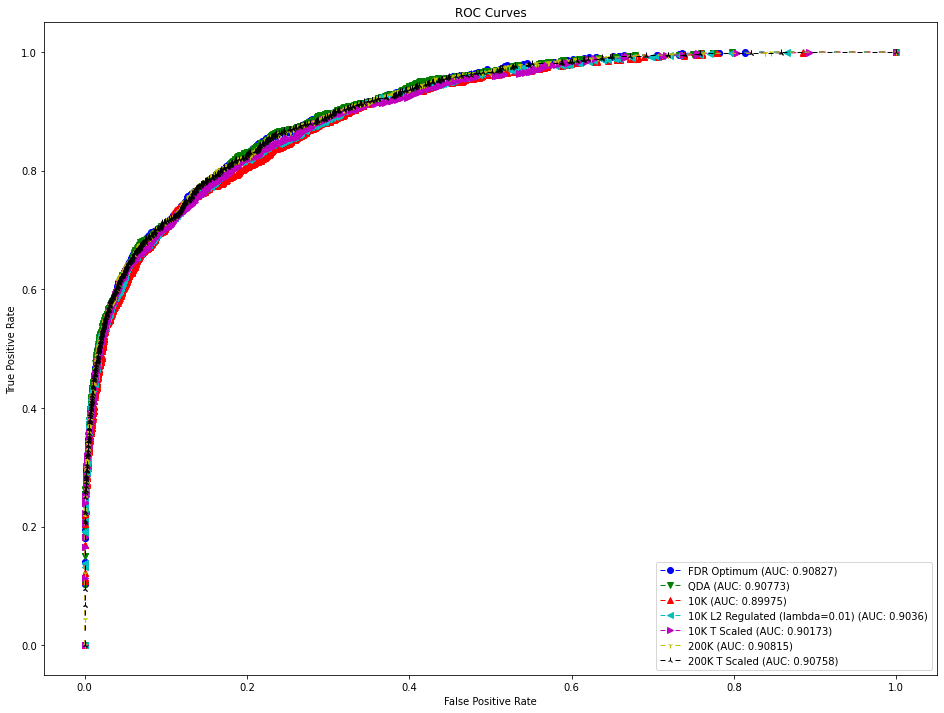

In [1454]:
plot_roc_curves(((1-fdr_vec), (1-qda_p_values), preds_mean_10k, preds_mean_10k_regul, preds_mean_10k_T_scaled, preds_mean_200k, preds_mean_200k_T_scaled), test_data[1], ("FDR Optimum", "QDA", "10K", "10K L2 Regulated (lambda=0.01)", "10K T Scaled", "200K", "200K T Scaled"), figname="roc-10k-and-above.png")

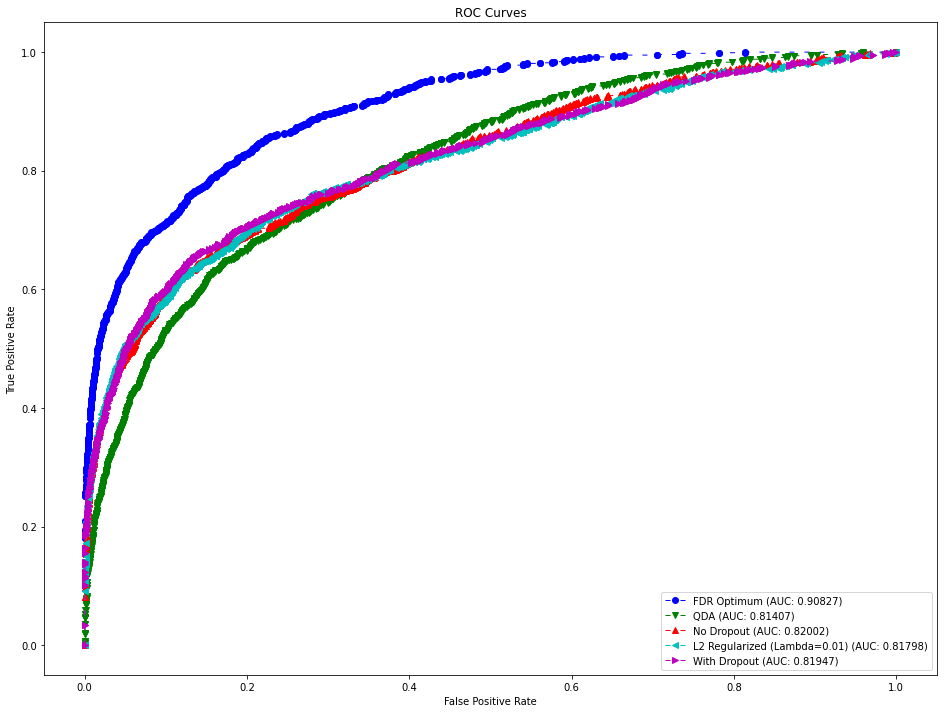

In [1455]:
plot_roc_curves(((1-fdr_vec), small_qda_probabilities[:,1], preds_mean_100_no_drop, preds_mean_100_no_drop_regul, preds_mean_100_dropout), test_data[1], ("FDR Optimum", "QDA", "No Dropout", "L2 Regularized (Lambda=0.01)", "With Dropout"), figname="roc-100-samples.png")